## Importing the Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Importing the Dataset

In [2]:
dataset = pd.read_csv("mls-salaries-2017.csv")
dataset

,club,last_name,first_name,position,base_salary,guaranteed_compensation
0,ATL,Almiron,Miguel,M,1912500.0,2297000.00
1,ATL,Ambrose,Mikey,D,65625.0,65625.00
2,ATL,Asad,Yamil,M,150000.0,150000.00
3,ATL,Bloom,Mark,D,99225.0,106573.89
4,ATL,Carleton,Andrew,F,65000.0,77400.00
...,...,...,...,...,...,...
611,VAN,Tornaghi,Paolo,GK,80000.0,80000.00
612,VAN,Waston,Kendall,D,350000.0,368125.00
613,VAN,Williams,Sheanon,D,175000.0,184000.00
614,NaN,Babouli,Mo,F,54075.0,54075.00


## Data Cleaning

In [3]:
# 1.
dataset.isnull().sum()

club                       2
last_name                  0
first_name                 4
position                   0
base_salary                0
guaranteed_compensation    0
dtype: int64

In [4]:
# 2.
dataset.dropna(inplace=True)

In [5]:
# 3.
dataset.isnull().sum()

club                       0
last_name                  0
first_name                 0
position                   0
base_salary                0
guaranteed_compensation    0
dtype: int64

In [6]:
# 4. For Outliers
Q1 = dataset["base_salary"].quantile(0.25)
Q3 = dataset["base_salary"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
dataset = dataset[(dataset["base_salary"] >= lower_bound) & (dataset["base_salary"] <= upper_bound)]
dataset

,club,last_name,first_name,position,base_salary,guaranteed_compensation
1,ATL,Ambrose,Mikey,D,65625.0,65625.00
2,ATL,Asad,Yamil,M,150000.0,150000.00
3,ATL,Bloom,Mark,D,99225.0,106573.89
4,ATL,Carleton,Andrew,F,65000.0,77400.00
6,ATL,Garza,Greg,D,150000.0,150000.00
...,...,...,...,...,...,...
609,VAN,Techera,Cristian,M,352000.0,377000.00
610,VAN,Teibert,Russell,M,126500.0,194000.00
611,VAN,Tornaghi,Paolo,GK,80000.0,80000.00
612,VAN,Waston,Kendall,D,350000.0,368125.00


## Setting up X and y for Model Training

In [7]:
X = dataset[["position","guaranteed_compensation"]].values
y = np.log1p(dataset["base_salary"]) 

## Encoding Categorical Variables

In [8]:
dataset["position"] = dataset["position"].astype(str)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[("encoder",OneHotEncoder(sparse_output=False),[0])],remainder="passthrough")
X = np.array(ct.fit_transform(X))

C:\Users\Baris\AppData\Local\Temp\ipykernel_19572\3298494022.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["position"] = dataset["position"].astype(str)


In [9]:
print(X)

[[1.0 0.0 0.0 ... 0.0 0.0 65625.0]
 [0.0 0.0 0.0 ... 0.0 0.0 150000.0]
 [1.0 0.0 0.0 ... 0.0 0.0 106573.89]
 ...
 [0.0 0.0 0.0 ... 0.0 0.0 80000.0]
 [1.0 0.0 0.0 ... 0.0 0.0 368125.0]
 [1.0 0.0 0.0 ... 0.0 0.0 184000.0]]


In [10]:
print(X.shape)
print(y.shape)

(543, 10)
(543,)


## Splitting the Dataset into Training and Test Sets

In [11]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

## Building and Training the XGBoost Model

In [13]:
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators=500, max_depth=10, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
predictions = xgb.predict(X_test)

## Evaluating Model Performance

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print("MAE:", mean_absolute_error(y_test, predictions))
print("MSE:", mean_squared_error(y_test, predictions))
print("RMSE:", np.sqrt(mean_squared_error(y_test, predictions)))

MAE: 0.06755762717958066
MSE: 0.014109612770240568
RMSE: 0.11878389103847613


## Visualizing Actual vs Predicted Values

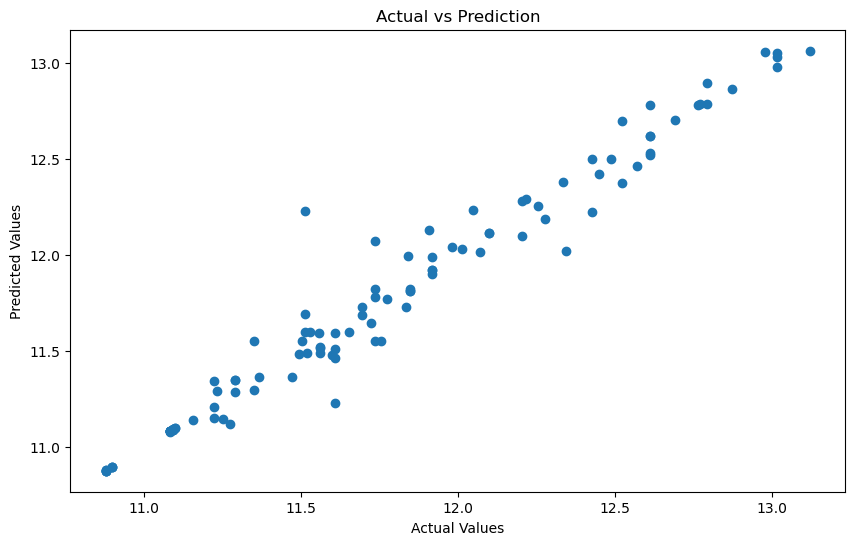

In [15]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, xgb.predict(X_test))
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Prediction")
plt.show()

## Results in Log Scale

In [16]:
results = np.concatenate((np.array(predictions).reshape(len(predictions),1),
                      np.array(y_test).reshape(len(y_test),1)),1)
print(results)

[[11.08226681 11.08221947]
 [11.52032566 11.56172515]
 [11.92002583 11.91839724]
 [12.78295803 12.79386209]
 [10.89754391 10.89814574]
 [11.08197594 11.08215793]
 [12.77965069 12.76569129]
 [11.23103046 11.60824474]
 [12.01430798 12.07259268]
 [11.55044746 11.73607702]
 [11.14355564 11.15626481]
 [10.87826157 10.87814153]
 [12.11187267 12.10071769]
 [11.5543623  11.3504183 ]
 [11.7693491  11.77535896]
 [11.08221817 11.08215793]
 [12.37624836 12.52454456]
 [12.37805939 12.33490991]
 [12.02917004 12.01370681]
 [11.35034466 11.28979441]
 [11.51790428 11.56172515]
 [11.08229065 11.08215793]
 [12.69928932 12.69158354]
 [11.46236134 11.60824474]
 [10.89756775 10.89814574]
 [11.5499382  11.50515536]
 [12.52142239 12.61154109]
 [11.36621284 11.36791125]
 [11.14561081 11.25162563]
 [12.11187267 12.10071769]
 [12.61752987 12.61154109]
 [12.18733692 12.27839796]
 [11.09923649 11.09969529]
 [11.50856495 11.6082811 ]
 [12.49832058 12.48751907]
 [11.34542656 11.22525673]
 [11.64597321 11.72446628]
 

## Applying Inverse Log Transformation

In [17]:
results[:, 0] = np.expm1(results[:, 0])  
results[:, 1] = np.expm1(results[:, 1])  

results_df = pd.DataFrame(results, columns=["Predictions", "Actual Values"])
print(results_df)

       Predictions  Actual Values
0     65007.077316       65004.00
1    100741.764485      105000.00
2    150244.488526      150000.00
3    356095.852601      360000.00
4     54042.464891       54075.00
..             ...            ...
104  109025.906087      100008.00
105  215114.973092      200004.00
106  325666.475460      274999.92
107  169523.121183      160000.00
108  204532.101608      100000.00

[109 rows x 2 columns]


## Errors

In [18]:
errors = results[:, 1] - results[:, 0]
errors

array([-3.07731592e+00,  4.25823551e+03, -2.44488526e+02,  3.90414740e+03,
        3.25351094e+01,  1.18288771e+01, -4.92006378e+03,  3.45657113e+04,
        9.90877780e+03,  2.11775163e+04,  8.84024784e+02, -6.36302020e+00,
       -2.01914978e+03, -1.92297319e+04,  7.78992674e+02, -3.91556959e+00,
        3.79023711e+04, -1.00314173e+04, -2.57127611e+03, -4.99374057e+03,
        4.50187685e+03, -8.62724774e+00, -2.51406136e+03,  1.49317040e+04,
        3.12465974e+01, -4.54462379e+03,  2.58532740e+04,  1.46789361e+02,
        7.74583171e+03, -2.01914978e+03, -1.80203122e+03,  1.87132602e+04,
        3.03430015e+01,  1.04401023e+04, -2.87801359e+03, -9.57675430e+03,
        9.32758687e+03, -1.11028761e+04, -1.33388503e+00,  3.29283114e+01,
        1.45512963e+03, -1.46029766e+04, -7.46063798e+01, -1.51209994e+04,
        2.98748627e+03,  9.64678936e+03,  1.10570808e+03,  5.19924159e+03,
        1.66870887e+02, -3.32741747e+04, -7.27590609e+03, -3.91764124e+02,
       -3.07731592e+00, -

## Visualizing Prediction Errors Distribution

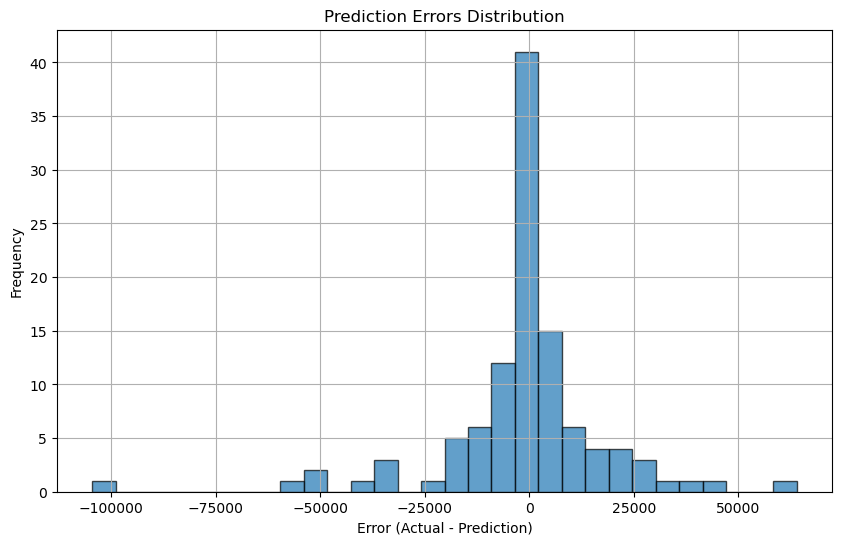

In [19]:
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, edgecolor='k', alpha=0.7)
plt.title("Prediction Errors Distribution")
plt.xlabel("Error (Actual - Prediction)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## Analyzing Error Distribution by Actual Values

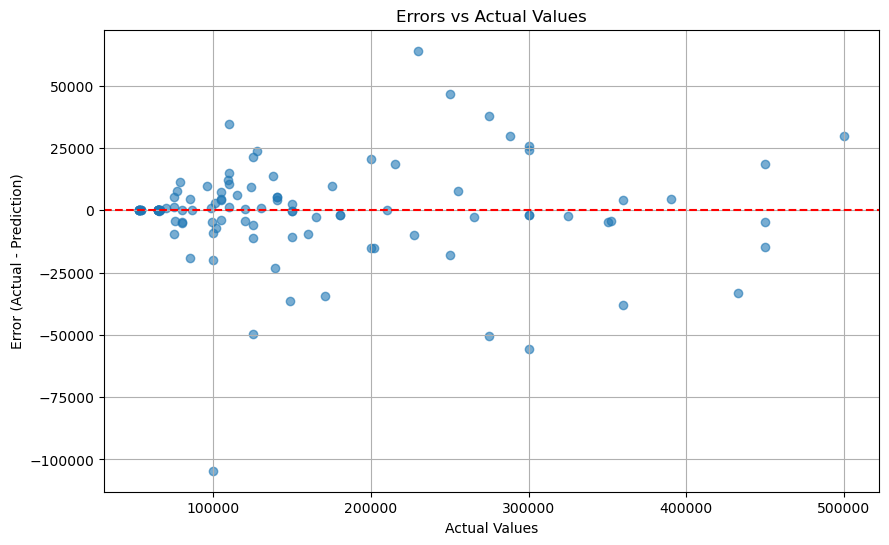

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(results[:, 1], errors, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Errors vs Actual Values")
plt.xlabel("Actual Values")
plt.ylabel("Error (Actual - Prediction)")
plt.grid(True)
plt.show()